<a href="https://colab.research.google.com/github/Durjoy18/Spam-SMS-DEtection/blob/main/Spam_SMS_detetion_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [40]:
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [41]:
from google.colab import drive

In [42]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os

drive_path = '/content/drive/My Drive/Colab Notebooks/'

# Check if the directory exists
if os.path.exists(drive_path):
    print(f"Contents of '{drive_path}':")
    for item in os.listdir(drive_path):
        print(item)
else:
    print(f"The directory '{drive_path}' does not exist. Please check the path.")

Contents of '/content/drive/My Drive/Colab Notebooks/':
Spam SMS detetion using bert.ipynb
Proteinss.csv
Untitled0.ipynb
spam.csv
spam email detection using  multinomial naive bayes.ipynb


In [44]:
df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/spam.csv", encoding='latin1')

In [45]:
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

In [46]:
print("Dataset shape:", df.shape)


Dataset shape: (5572, 2)


In [47]:
df = df.rename(columns={df.columns[0]: "label", df.columns[1]: "text"})
df["label"] = df["label"].str.lower().map({"ham": 0, "spam": 1})

In [48]:
print(df["label"].value_counts())
print("\nSample data:")

label
0    4825
1     747
Name: count, dtype: int64

Sample data:


In [49]:
print(df.head(3))

   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...


In [50]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

In [51]:
df["text"] = df["text"].apply(clean_text)

print("Before cleaning:")
print(df["text"].iloc[1])

Before cleaning:
ok lar joking wif u oni


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.2, random_state=42, stratify=df["label"]
)

In [53]:
print("Train size:", len(X_train))
print("Test size :", len(X_test))


Train size: 4457
Test size : 1115


In [54]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [55]:
train_enc = tokenizer(
    list(X_train), truncation=True, padding=True, max_length=128
)

In [56]:
test_enc = tokenizer(
    list(X_test), truncation=True, padding=True, max_length=128
)

In [57]:
print(train_enc["input_ids"][0][:10])

[101, 2183, 2006, 2498, 2307, 9061, 102, 0, 0, 0]


In [58]:
class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.values

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [59]:
train_ds = SpamDataset(train_enc, y_train)
test_ds = SpamDataset(test_enc, y_test)


In [60]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
training_args = TrainingArguments(
    output_dir="./bert_out",
    # evaluation_strategy="epoch", # Commented out due to TypeError: unexpected keyword argument
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_steps=50,
    save_strategy="no",
    report_to="none"
)


In [62]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class=tokenizer
)

In [63]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.217000
100,0.099100
150,0.080100
200,0.067800
250,0.065300
300,0.047900
350,0.030300
400,0.031400
450,0.028700
500,0.007000


TrainOutput(global_step=558, training_loss=0.06180132821362506, metrics={'train_runtime': 11155.6465, 'train_samples_per_second': 0.799, 'train_steps_per_second': 0.05, 'total_flos': 586342986869760.0, 'train_loss': 0.06180132821362506, 'epoch': 2.0})

In [64]:
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)
y_prob = torch.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()

In [65]:
print("First 10 actual labels   :", y_test.values[:10])
print("First 10 predicted labels:", y_pred[:10])

First 10 actual labels   : [0 0 0 1 0 0 0 0 0 0]
First 10 predicted labels: [0 0 0 1 0 0 0 0 0 0]


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy : 0.989237668161435
Precision: 0.9790209790209791
Recall   : 0.9395973154362416
F1-score : 0.958904109589041

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.94      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [69]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[963   3]
 [  9 140]]


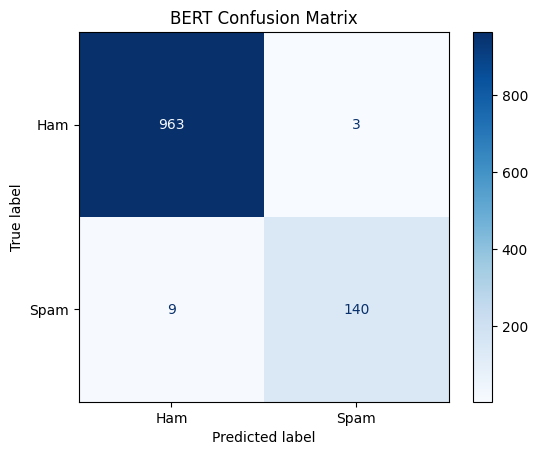

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"])
disp.plot(cmap="Blues")
plt.title("BERT Confusion Matrix")
plt.show()

ROC AUC: 0.9966512429307878


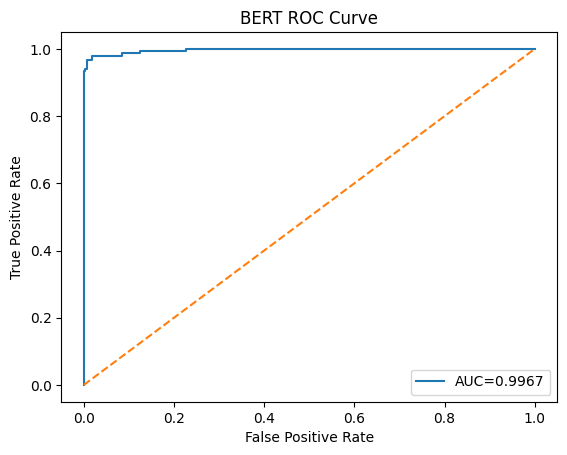

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", auc)

plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BERT ROC Curve")
plt.legend()
plt.show()